In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
%matplotlib inline

In [2]:
IMG_WIDTH= 28 
IMG_HEIGHT= 28 
IMG_CHANNELS=1
IMG_DIM = (IMG_HEIGHT, IMG_WIDTH)
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
x_train = x_train.reshape(-1, IMG_WIDTH, IMG_HEIGHT,IMG_CHANNELS) 
print(x_train.shape)
print(np.unique(y_train))

(60000, 28, 28, 1)
[0 1 2 3 4 5 6 7 8 9]


## Display data

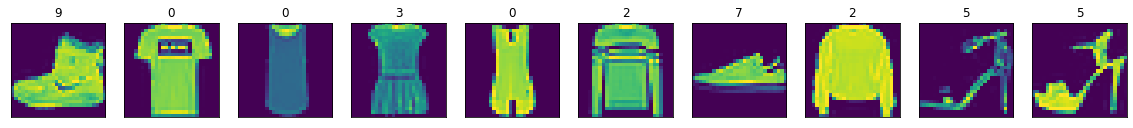

In [4]:
plt.figure(figsize=(20, 4))
n=10
for i in range(10):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.title(y_train[i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

In [5]:
# Create the Encoder and Decoder

#pass the gray scale input image of size(28,28,1)
inputs = tf.keras.Input(shape=input_shape, name='input_layer')
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)

# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)
encoded_shape= tf.keras.backend.int_shape(encoded)
print(encoded_shape)
encoded = tf.keras.layers.Flatten()(encoded)
encoded = tf.keras.layers.Dense(10)(encoded)
encoder=tf.keras.Model(inputs, encoded, name='encoder')
encoder.summary()
latent=tf.keras.Input(shape=(10,))
#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu.
decoded= tf.keras.layers.Dense(np.prod(encoded_shape[1:]))(latent)
decoded= tf.keras.layers.Reshape((encoded_shape[1], encoded_shape[2], encoded_shape[3]))(decoded)
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 1, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)
# output
outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

decoder= tf.keras.Model(latent, outputs, name="decoder")
decoder.summary()

(None, 7, 7, 64)
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 28, 28, 32)        128       
_________________________________________________________________
leaky_relu_1 (LeakyReLU)     (None, 28, 28, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 14, 64)        18496     
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_relu_2 (LeakyReLU)     (None, 14, 14

In [6]:
Autoencoder = tf.keras.Model(inputs, decoder(encoder(inputs)),name="autoencoder")  
Autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 10)                87754     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         127745    
Total params: 215,499
Trainable params: 214,859
Non-trainable params: 640
_________________________________________________________________


In [7]:
# SSIM Loss functtion
def ssim_loss(y_true, y_pred):
  return 1- tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

In [8]:
# compile the model 
optimizer = 'adam'
Autoencoder.compile(optimizer=optimizer, loss=ssim_loss, )

#training
Autoencoder.fit(x_train, x_train, batch_size=64, epochs=20)

Epoch 1/20
938/938 [==============================] - 12s 13ms/step - loss: 0.3060
Epoch 2/20
938/938 [==============================] - 12s 13ms/step - loss: 0.2557
Epoch 3/20
938/938 [==============================] - 12s 13ms/step - loss: 0.2442
Epoch 4/20
938/938 [==============================] - 12s 13ms/step - loss: 0.2374
Epoch 5/20
938/938 [==============================] - 12s 13ms/step - loss: 0.2331
Epoch 6/20
938/938 [==============================] - 12s 13ms/step - loss: 0.2295
Epoch 7/20
938/938 [==============================] - 12s 13ms/step - loss: 0.2271
Epoch 8/20
938/938 [==============================] - 12s 13ms/step - loss: 0.2245
Epoch 9/20
938/938 [==============================] - 12s 13ms/step - loss: 0.2229
Epoch 10/20
938/938 [==============================] - 12s 13ms/step - loss: 0.2209
Epoch 11/20
938/938 [==============================] - 12s 13ms/step - loss: 0.2194
Epoch 12/20
938/938 [==============================] - 12s 13ms/step - loss: 0.2184
E

## Dimensionality Reduction

In [9]:
feature_model = tf.keras.Model(inputs=encoder.input, outputs=encoder.output)
features = feature_model.predict(x_test)

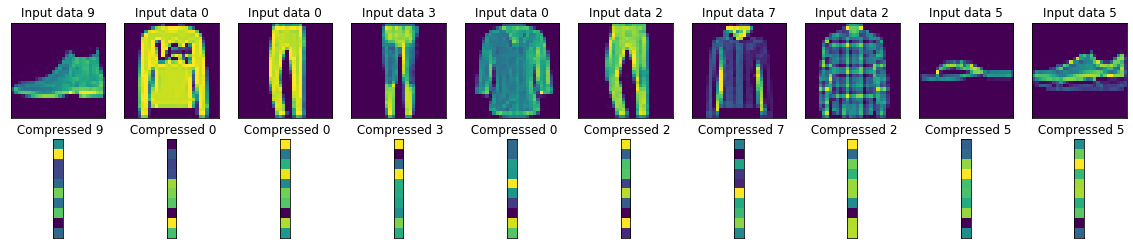

In [10]:
plt.figure(figsize=(20, 4))
n=10
for i in range(10):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.title("Input data "+ str(y_train[i]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(features[i].reshape(10, 1))
    plt.title(" Compressed " + str(y_train[i]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

In [11]:
fashionMNIST_df= pd.DataFrame(features)
fashionMNIST_df['target']=y_test

In [12]:
fashionMNIST_df.head(10)

,0,1,2,3,4,5,6,7,8,9,target
0,1.359445,19.554741,-8.847407,-8.576919,-4.030847,12.054169,-3.292056,10.314418,-16.330973,-4.465891,9
1,-9.019423,-0.409941,-2.639545,-1.519979,19.535995,18.153919,15.817653,-9.554475,24.678732,14.394195,2
2,1.469576,-18.567877,-10.407115,0.464967,-16.108700,-5.539824,-7.258255,-31.418062,-2.433858,-13.847392,1
3,2.844498,-23.917770,-14.795713,3.099912,-7.063379,-7.269739,-8.104588,-10.680129,-2.259466,-7.126454,1
4,-0.723819,-0.900314,3.926152,3.445698,13.684289,3.057832,-4.384345,-8.275729,12.262538,7.792189,6
5,6.771614,-13.210787,-1.226924,-0.532132,-16.429529,4.296983,-13.623621,-22.379709,7.366991,-18.731453,1
6,0.419034,-8.885134,3.806039,-5.443512,-6.531500,12.891892,4.409781,5.904293,9.115767,1.496194,4
7,9.348615,-1.273846,5.834198,3.585916,6.900534,6.857492,0.842590,-7.096363,7.450719,7.532602,6
8,-11.687260,-9.930750,8.743522,14.816822,3.539459,4.037300,0.271009,8.804651,-22.901937,-4.043888,5
9,-7.411941,2.433916,10.437487,-1.223240,5.416492,5.934606,-3.002246,1.367951,-25.078466,-13.369760,7


In [13]:
#recon_model = tf.keras.Model(inputs=encoder.output, outputs=decoder.output)
reconstruction_model = tf.keras.Model(latent, outputs, name="decoder")
reconstruction_model.summary()
recon_image = reconstruction_model.predict(features)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              34496     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv_transpose_1 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
batchnorm_4 (BatchNormalizat (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_relu_4 (LeakyReLU)     (None, 14, 14, 64)        0         
_________________________________________________________________
conv_transpose_2 (Conv2DTran (None, 28, 28, 64)        3692

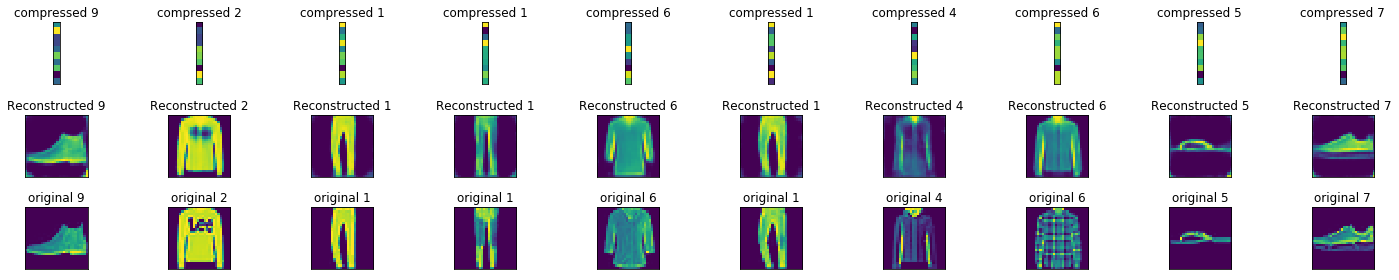

In [14]:
plt.figure(figsize=(20, 4))
n=10
for i in range(10):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(features[i].reshape(10, 1))
    plt.title("compressed " + str(y_test[i]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + n+1)
    plt.imshow(recon_image[i].reshape(28, 28))
    plt.title("Reconstructed " + str(y_test[i]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 2*n+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.title("original " + str(y_test[i]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [15]:
test_x_predictions = Autoencoder.predict(x_test)
#mse = np.mean(np.power(x_train - test_x_predictions, 2), axis=1)
test_x_predictions.shape

(10000, 28, 28, 1)

In [16]:
print(test_x_predictions[1].shape)
print(x_test[1].shape)

(28, 28, 1)
(28, 28, 1)


C:\Users\khandelwalr\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\measure\_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


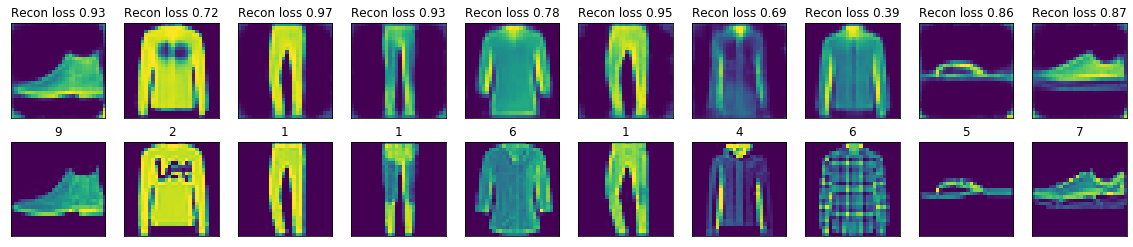

In [17]:
from skimage.measure import compare_ssim
plt.figure(figsize=(20, 4))
n=10
for i in range(10):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_x_predictions[i].reshape(28, 28))
    plt.title("Recon loss " + str(np.round(compare_ssim(test_x_predictions[i], 
                                                        x_test[i], 
                                                        multichannel=True ,
                                                        gaussian_weights=True ),2)))
   
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.title(y_test[i])
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

plt.show()


## Clustering

In [18]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
#kmeans_img = MiniBatchKMeans(n_clusters=10, init='k-means++', max_iter=5000, n_init=20)
wcss_img=[]
max_silhouette=[]
for i in range(2,12):
    kmeans_img = KMeans(n_clusters=i, init='k-means++', max_iter=10000, n_init=20)
    #kmeans_img = MiniBatchKMeans(n_clusters=i, init='k-means++', max_iter=4000, n_init=20)
    y_means_img = kmeans_img.fit_predict(features)
    wcss_img.append(kmeans_img.inertia_)
    silhouette_avg = silhouette_score(features, y_means_img)
    max_silhouette.append(silhouette_avg)
    print("For n_clusters =", i,
              "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.26902676
For n_clusters = 3 The average silhouette_score is : 0.2588945
For n_clusters = 4 The average silhouette_score is : 0.28614315
For n_clusters = 5 The average silhouette_score is : 0.24030271
For n_clusters = 6 The average silhouette_score is : 0.2554348
For n_clusters = 7 The average silhouette_score is : 0.25637916
For n_clusters = 8 The average silhouette_score is : 0.25961626
For n_clusters = 9 The average silhouette_score is : 0.2456811
For n_clusters = 10 The average silhouette_score is : 0.24883254
For n_clusters = 11 The average silhouette_score is : 0.2479796


C:\Users\khandelwalr\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


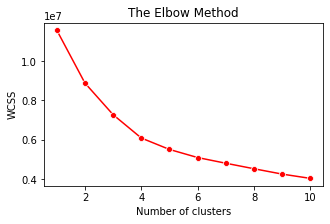

In [19]:
# Using the elbow method to find the optimal number of clusters
import seaborn as sns
max_k=11 # max no. of clusters to be evaluated
wcss = []
for i in range(1, max_k):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(features)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)
#plotting the data 
plt.figure(figsize=(5,3))
sns.lineplot(range(1, max_k), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [20]:
kmeans_img = KMeans(n_clusters=10, init='k-means++', max_iter=10000, n_init=20, random_state=0)
y_means_img = kmeans_img.fit_predict(features)

In [83]:
data_cluster= pd.DataFrame(y_test, columns=['Original class'])
data_cluster['cluster']= y_means_img

data_cluster.head(4)

,Original class,cluster
0,9,1
1,2,9
2,1,2
3,1,2


## get the clustered data for a cluster

<Figure size 1440x720 with 0 Axes>

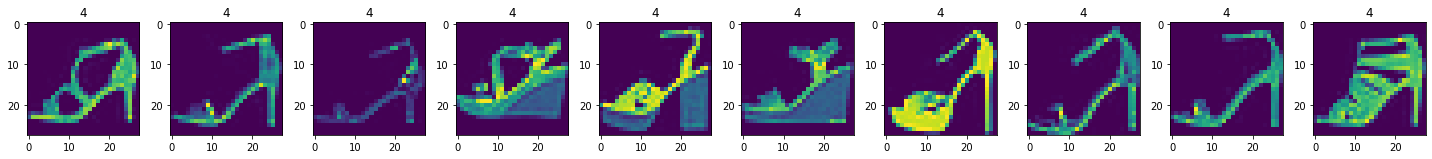

In [118]:
plt.figure(figsize=(20, 10))
i_rows=1
i_cols=10
k=0
selected_col=data_cluster.index[data_cluster['cluster'] == 4]
figure, axes = plt.subplots(nrows=i_rows, ncols=i_cols, figsize=(20, 20))

for j in range(i_rows):
    for i in range(i_cols):
        if i_rows==1:
            axes[ i].imshow(x_test[selected_col[k]].reshape(28, 28))
            axes[i].set_title(y_means_img[selected_col[k]])
        else:
            
            axes[j, i].imshow(x_test[selected_col[k]].reshape(28, 28))
            axes[j,i].set_title(y_means_img[selected_col[k]])
        k+=1
plt.tight_layout()
plt.show()


## display sample data for a class from training data

In [23]:
train_filter = [key for (key, label) in enumerate(y_train) if int(label) == 8 ]
train_filter[0]

23

In [24]:
# predict the train data using Autoencoder
train_x_pred= Autoencoder.predict(x_train[train_filter])

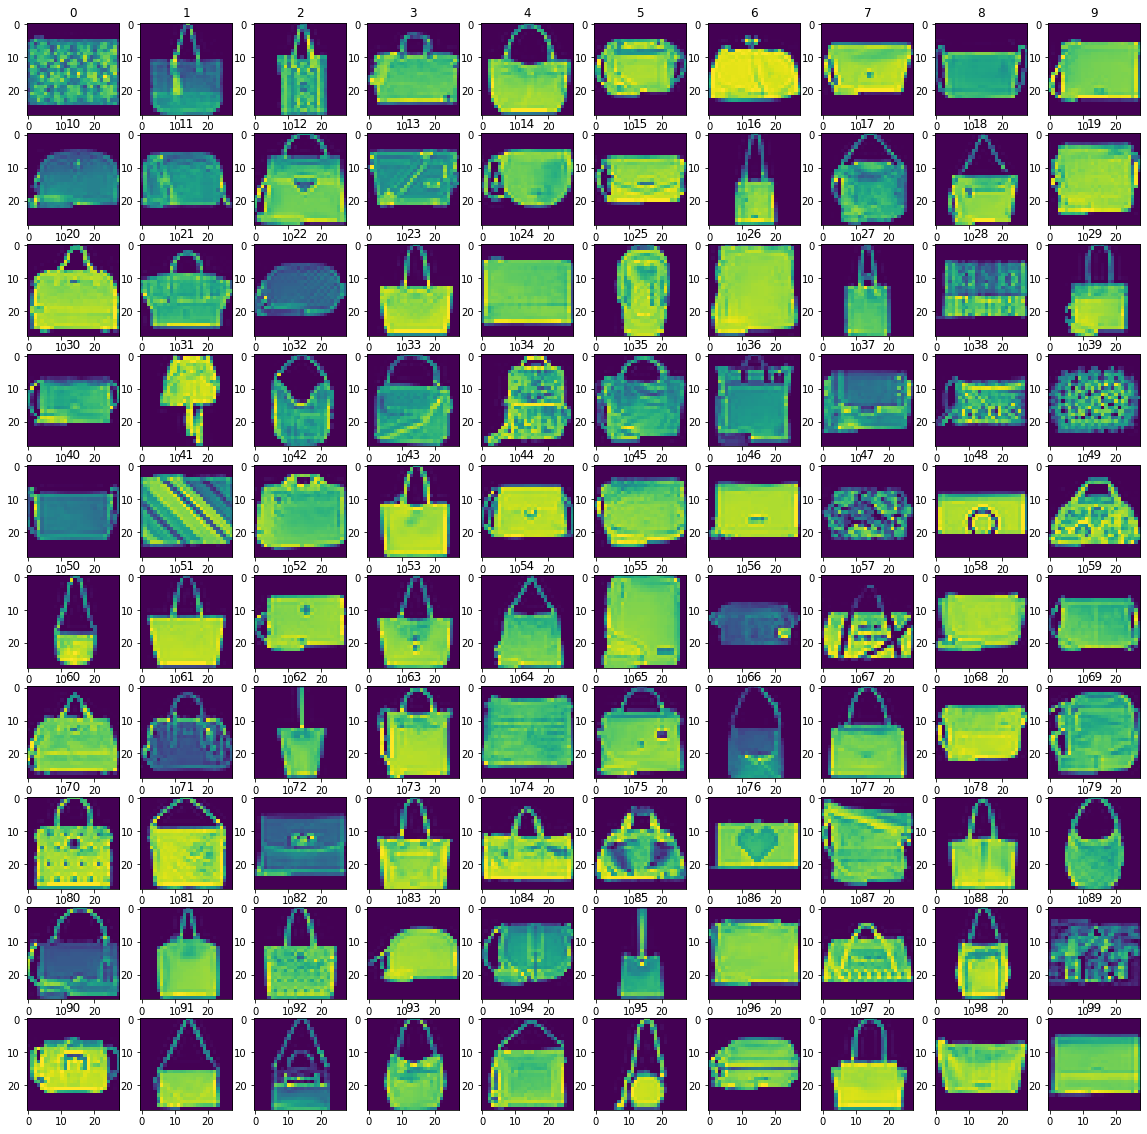

In [25]:
n=10
k=0
figure, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))
for j in range(10):
    for i in range(10):
        
        axes[j, i].imshow(x_train[train_filter[k]].reshape(28, 28))
        #axes[j,i].set_title(y_train[train_filter[k]])
        
        axes[j,i].set_title(k)
        #plt.title(str(y_test[k]) + " cluster no. " + str( y_means_img[selected_col[k]]))
        #plt.gray()
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)
        k+=1
#plt.tight_layout()

plt.show()

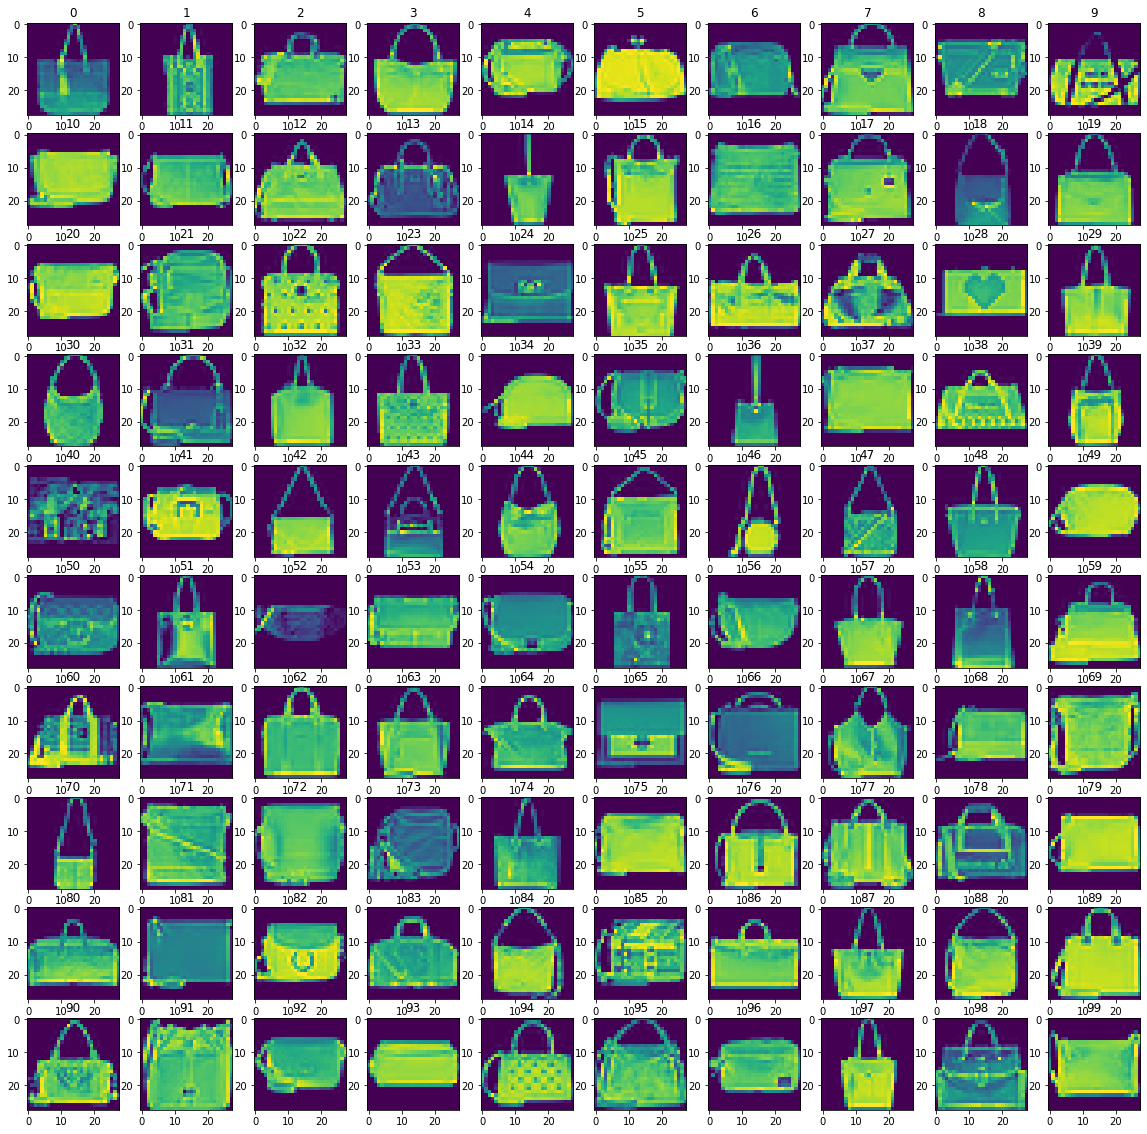

In [26]:

#
sample_filter=[ 35, 57, 99, 100, 105, 109,152, 156, 161,587, 
               610, 611, 613, 621, 628, 630, 633, 647, 653, 654, 
               660, 661, 671, 675, 681, 695, 708, 721, 724, 736, 
               747, 750, 758, 768, 769, 794, 801, 811, 818, 828, 
               847, 853, 879, 887, 894, 901, 907,1059, 1065, 1083, 
               1095, 59702, 59703, 59710, 59729, 59730, 59735, 59739, 59742, 59748, 
               59766,59767, 59790, 59798, 59799, 59807, 59810, 59825, 59830, 59835, 
               59838, 59841, 3601, 3603, 3621, 3633, 3641, 3664, 3670, 3680, 
               3700, 3718, 3740, 3744, 3748, 3768, 3772, 3779, 3781,4520, 
               4521, 4530, 4532, 4536, 4539, 4541, 4591, 4592, 4596, 
               4614, 4620, 4622,  4630, 4631, 59858, 59875, 59894, 59919, 59923, 
               59929, 59942, 59948, 59949, 59962, 59967, 59994,
              2473, 2475, 2487, 2498, 2502, 2506, 2510, 2521, 2537, 2541, 2554, 2565, 2578, 2589, 2593, 2598, 2602]
n=10
k=0
figure, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))
for j in range(10):
    for i in range(10):
        
        axes[j, i].imshow(x_train[sample_filter[k]].reshape(28, 28))
        axes[j,i].set_title(k)
        
        k+=1

plt.show()

In [27]:
train_x_pred= Autoencoder.predict(x_train[sample_filter])

No. of images in a cluster  591  No. of images labelled  355


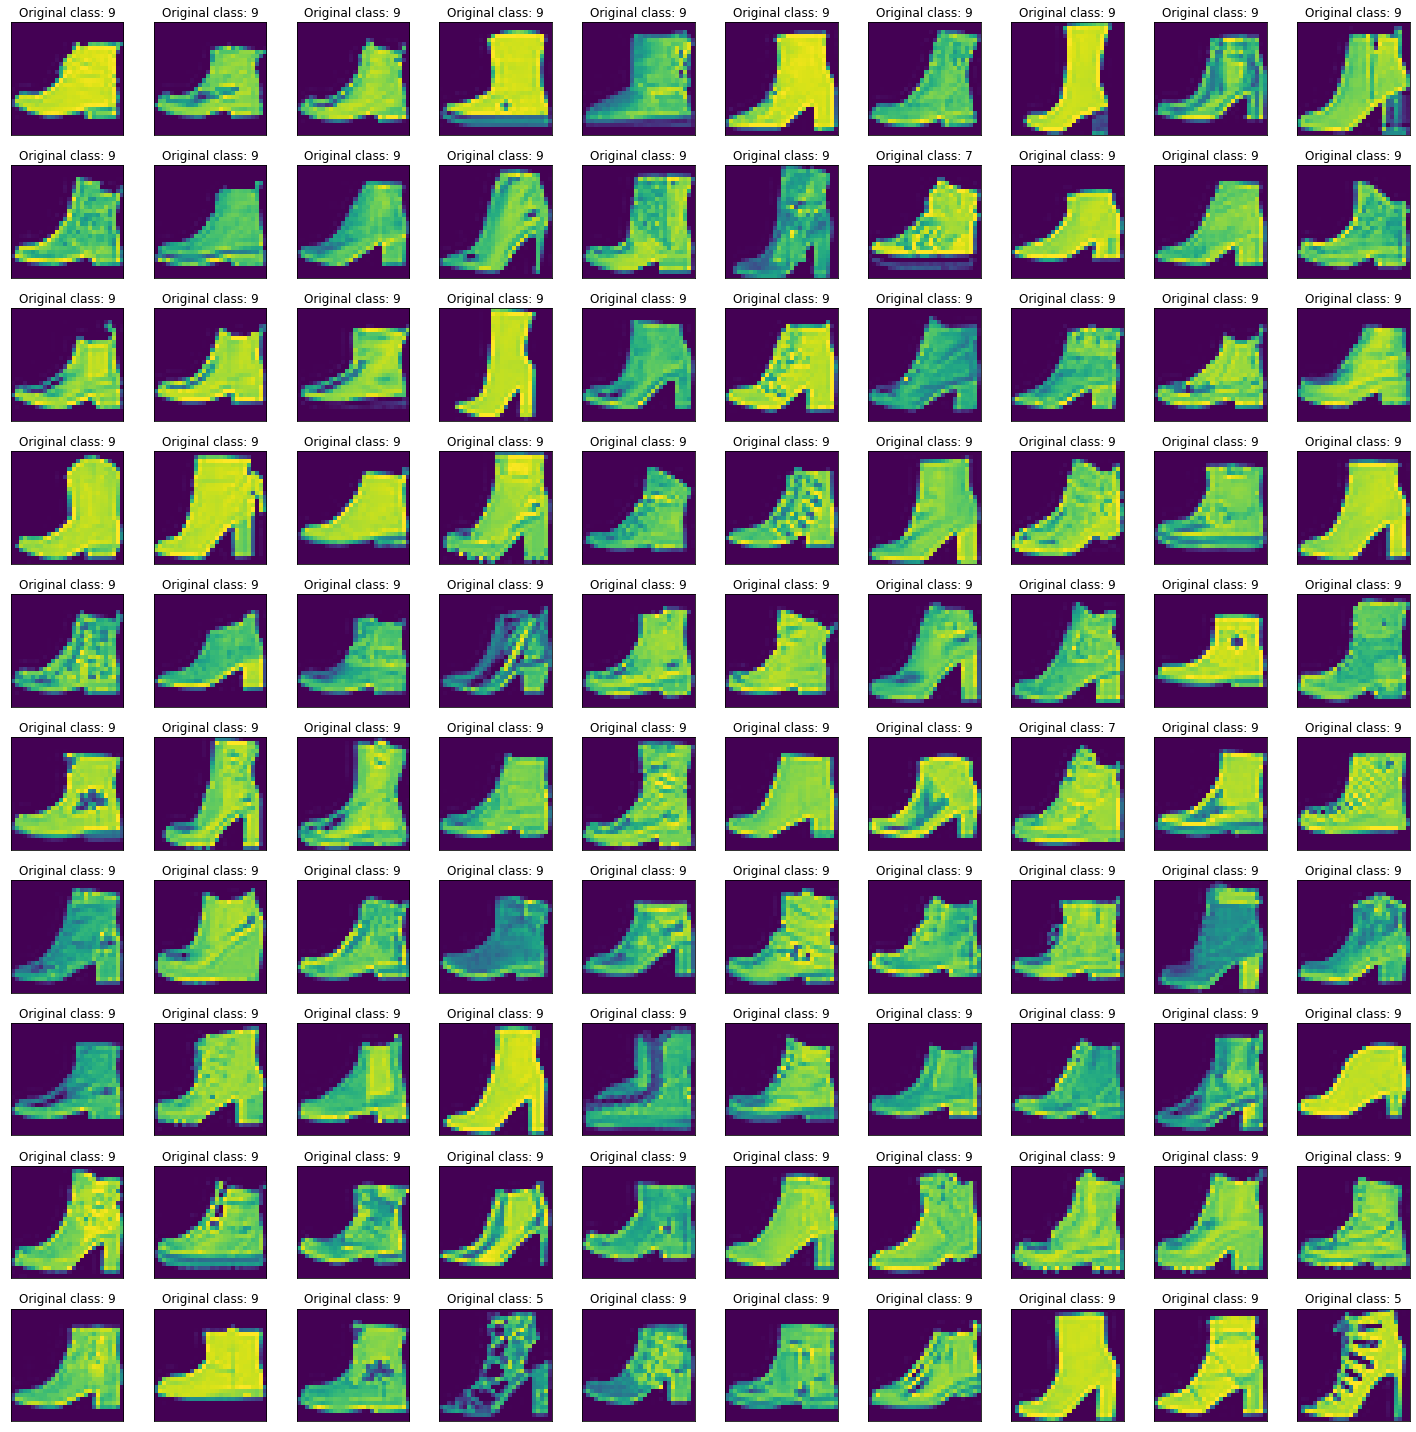

In [120]:
#cluster 0- T shirt, cluster 1- sneakers cluster 2- bags 3- Trouser 4-
# Fashion MNISt 0-T-shirt 1- Trousers 2- pullover 3- Dress
#4-coat 5 -sandal 6- shirt 7 - sneaker 8-bag 9- ankle boot

# 2-9- pullover
#9-6= ankel boot
train_filter = [key for (key, label) in enumerate(y_train) if int(label) == 9 ]
train_x_pred= Autoencoder.predict(x_train[train_filter])
good_labeled_image_idx=[]
selected_col=data_cluster.index[data_cluster['cluster'] ==6]


SSIM_THRESHOLD=0.6
for i in range(len(selected_col)):
    if ssim_loss(test_x_predictions[selected_col[i]],train_x_pred[i])<SSIM_THRESHOLD: 
        good_labeled_image_idx.append(selected_col[i])
print("No. of images in a cluster ", len(selected_col), " No. of images labelled ", len(good_labeled_image_idx))
rows=int(len(good_labeled_image_idx)/10)
rows_selected=rows if rows< 10 else 1 if rows ==1 else 10
figure, axes = plt.subplots(nrows=rows_selected, ncols=10, figsize=(20, 20))

n=10
k=0
for j in range(rows_selected):
    for i in range(10):
        
        axes[j, i].set_title(str("Original class: "+ str(y_test[good_labeled_image_idx[k]])))
        axes[j, i].imshow(x_test[good_labeled_image_idx[k]].reshape(28, 28))
        axes[j,i].get_xaxis().set_visible(False)
        axes[j,i].get_yaxis().set_visible(False)
        k+=1
plt.tight_layout()

plt.show()

In [119]:

selected_col=data_cluster.index[data_cluster['cluster'] ==6]
SSIM_THRESHOLD=[0.10, 0.20, 0.30, 0.40, 0.50,0.60,0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
for t in range(len(SSIM_THRESHOLD)):
    good_labeled_image_idx=[]
    for i in range(len(selected_col)):
        if ssim_loss(test_x_predictions[selected_col[i]],train_x_pred[i])<SSIM_THRESHOLD[t]: 
            good_labeled_image_idx.append(selected_col[i])
    print("No. of images in a cluster ", len(selected_col), 
          " No. of images labelled for SSIM Threshold ",SSIM_THRESHOLD[t], " = ", len(good_labeled_image_idx))

No. of images in a cluster  591  No. of images labelled for SSIM Threshold  0.1  =  1
No. of images in a cluster  591  No. of images labelled for SSIM Threshold  0.2  =  14
No. of images in a cluster  591  No. of images labelled for SSIM Threshold  0.3  =  53
No. of images in a cluster  591  No. of images labelled for SSIM Threshold  0.4  =  119
No. of images in a cluster  591  No. of images labelled for SSIM Threshold  0.5  =  224
No. of images in a cluster  591  No. of images labelled for SSIM Threshold  0.6  =  355
No. of images in a cluster  591  No. of images labelled for SSIM Threshold  0.65  =  432
No. of images in a cluster  591  No. of images labelled for SSIM Threshold  0.7  =  484
No. of images in a cluster  591  No. of images labelled for SSIM Threshold  0.75  =  535
No. of images in a cluster  591  No. of images labelled for SSIM Threshold  0.8  =  563
No. of images in a cluster  591  No. of images labelled for SSIM Threshold  0.85  =  579
No. of images in a cluster  591  

No. of images in a cluster  591
587 58


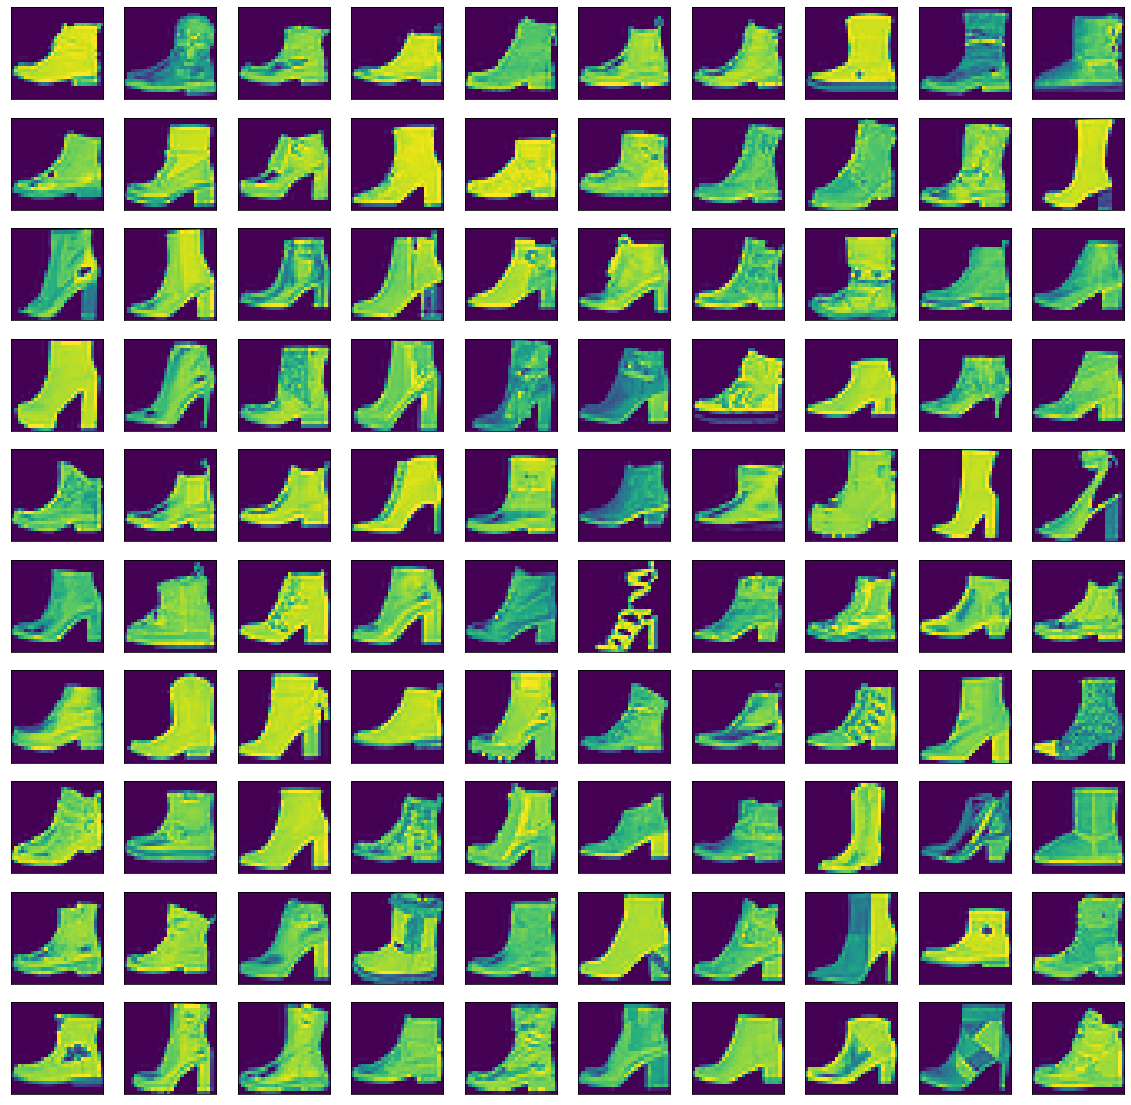

In [31]:
#cluster 0- T shirt, cluster 1- sneakers cluster 2- bags 3- Trouser 4-
# Fashion MNISt 0-T-shirt 1- Trousers 2- pullover 3- Dress
#4-coat 5 -sandal 6- shirt 7 - sneaker 8-bag 9- ankle boot

# 3 and 3 - dress
# 4 and 9-boots
# 5 and 8 bags
train_filter = [key for (key, label) in enumerate(y_train) if int(label) == 9 ]
train_x_pred= Autoencoder.predict(x_train[train_filter])
good_labeled_image_idx=[]
selected_col=data_cluster.index[data_cluster['cluster'] ==6]
print("No. of images in a cluster ", len(selected_col))
#num_range=len(train_filter) if len(selected_col)> len(train_filter) else len(selected_col)
#print(num_range)
for i in range(len(selected_col)):
    #if ssim_loss(test_x_predictions[selected_col[i]],train_x_pred[i])<0.95: 
    if np.round(compare_ssim(test_x_predictions[selected_col[i]],train_x_pred[i], multichannel=True ,gaussian_weights=True ),2)  >0.1:
        #print(y_test[selected_col[i]])
        good_labeled_image_idx.append(selected_col[i])
rows=int(len(good_labeled_image_idx)/10)
print(len(good_labeled_image_idx), rows)
rows_selected=rows if rows< 10 else 10
figure, axes = plt.subplots(nrows=rows_selected, ncols=10, figsize=(20, 20))

n=10
k=0
for j in range(rows_selected):
    for i in range(10):
        
        axes[j, i].imshow(x_test[good_labeled_image_idx[k]].reshape(28, 28))
        #axes[j,i].set_title(y_means_img[good_labeled_inage_idx[k]])
        #plt.title(str(y_test[k]) + " cluster no. " + str( y_means_img[selected_col[k]]))
        #plt.gray()
        axes[j,i].get_xaxis().set_visible(False)
        axes[j,i].get_yaxis().set_visible(False)
        k+=1
#plt.tight_layout()

plt.show()